In [ ]:
# To upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"snehithaanpur","key":"d50bded4c181e2e220e57992394e3a65"}'}

In [ ]:
# Changing the prath to the .kaggle folder
!cp kaggle.json ~/.kaggle/ 
#  Changing the permissions to perform read and write access
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the dogs-vs-cats dataset 
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:35<00:00, 26.1MB/s]
100% 812M/812M [00:35<00:00, 23.9MB/s]


In [ ]:
# Unzipping dogs-vs-cats dataset file
!unzip -qq dogs-vs-cats.zip

In [ ]:
# Unzipping train sample 
!unzip -qq train.zip

Training from scratch model

In [ ]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
#Building the model and running the model summary 
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
# Configuration of the model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Declaring the image size and batch size to read the images from train. validation and test directories
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 73ms/step - loss: 0.7021 - accuracy: 0.5025 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6919 - accuracy: 0.5325 - val_loss: 0.6876 - val_accuracy: 0.5080
Epoch 3/30
63/63 [==============================] - 5s 77ms/step - loss: 0.6928 - accuracy: 0.5760 - val_loss: 0.6736 - val_accuracy: 0.5830
Epoch 4/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6483 - accuracy: 0.6270 - val_loss: 0.6167 - val_accuracy: 0.6490
Epoch 5/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6177 - accuracy: 0.6650 - val_loss: 0.6120 - val_accuracy: 0.6580
Epoch 6/30
63/63 [==============================] - 4s 62ms/step - loss: 0.5805 - accuracy: 0.6970 - val_loss: 0.6090 - val_accuracy: 0.6810
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5623 - accuracy: 0.7030 - val_loss: 0.5802 - val_accuracy: 0.7000
Epoch 8/30
6

In [ ]:
# Testing the model 
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.5654 - accuracy: 0.7110
Test accuracy: 0.711


Data Augumentation

In [ ]:
# Declaring Data Augumentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
# Building the model and configuing it 
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


63/63 [==============================] - 18s 208ms/step - loss: 0.6959 - accuracy: 0.5100 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 13s 205ms/step - loss: 0.6938 - accuracy: 0.5165 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 13s 209ms/step - loss: 0.6863 - accuracy: 0.5570 - val_loss: 0.6722 - val_accuracy: 0.5910
Epoch 4/100
63/63 [==============================] - 13s 208ms/step - loss: 0.7187 - accuracy: 0.5590 - val_loss: 0.6435 - val_accuracy: 0.6120
Epoch 5/100
63/63 [==============================] - 13s 206ms/step - loss: 0.6392 - accuracy: 0.6350 - val_loss: 0.6133 - val_accuracy: 0.6710
Epoch 6/100
63/63 [==============================] - 15s 226ms/step - loss: 0.6255 - accuracy: 0.6505 - val_loss: 0.6911 - val_accuracy: 0.5590
Epoch 7/100
63/63 [==============================] - 13s 206ms/step - loss: 0.6053 - accuracy: 0.6685 - val_loss: 0.6752 - val_accuracy: 0.6390
Epoc

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4961 - accuracy: 0.7825
Test accuracy: 0.783


Question 2

In [ ]:
# Creating directories and assiging images to training, validation and test directories
# Increasing the training sample from 1000 to 2000
import os
import shutil
import pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_IncreasedTrainSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 2000 samples, test has 1000 samples, and validation has 500 samples
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3500)


FileExistsError: ignored

In [ ]:
# Building the model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Configuring the model 
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 65ms/step - loss: 0.7005 - accuracy: 0.5115 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6938 - accuracy: 0.5235 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6916 - accuracy: 0.5300 - val_loss: 0.6793 - val_accuracy: 0.6200
Epoch 4/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6771 - accuracy: 0.5820 - val_loss: 0.6777 - val_accuracy: 0.5620
Epoch 5/30
63/63 [==============================] - 5s 77ms/step - loss: 0.6608 - accuracy: 0.6205 - val_loss: 0.7320 - val_accuracy: 0.5630
Epoch 6/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6262 - accuracy: 0.6560 - val_loss: 0.6066 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 0.5915 - accuracy: 0.6975 - val_loss: 0.5751 - val_accuracy: 0.6850
Epoch 8/30
63

In [ ]:
# Testing the model 
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.5616 - accuracy: 0.7130
Test accuracy: 0.713


Question 3

In [ ]:
# Creating directories and assiging images to training, validation and test directories
# Increasing the training sample from 1000 to 2000
import os
import shutil
import pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_OptimalTrainSamples1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 1500 samples, test has 1000 samples, and validation has 500 samples
# make_subset("train", start_index=0, end_index=3500)
# make_subset("validation", start_index=2500, end_index=3000)
# make_subset("test", start_index=3000, end_index=4000)


In [ ]:
# Building the model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Configuring the model 
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator


# Train the model with varying training sample sizes
sample_sizes = [3500,4000,4500,5000]
history_dict = []
for size in sample_sizes:
    # Set up the training subset
    make_subset("temp_train", start_index=1500, end_index=size)
    make_subset("validation", start_index=size, end_index=size+500)
    make_subset("test", start_index=size+500, end_index=size+1500)
    train_dataset = image_dataset_from_directory(
      new_base_dir / "temp_train", 
      image_size=(180, 180), 
      batch_size=20)
    # Using the callbacks function to monitor validation loss and running the model
  
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")]

    history = model.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks=callbacks)
    
    test_model = keras.models.load_model("convnet_from_scratch.keras")
    test_loss, test_acc = test_model.evaluate(test_dataset)
    history_dict.append(test_acc)
    print(f"Test accuracy: {test_acc:.3f}")  
 

Found 4000 files belonging to 2 classes.
Epoch 1/30
200/200 [==============================] - 10s 36ms/step - loss: 0.7077 - accuracy: 0.5217 - val_loss: 0.6779 - val_accuracy: 0.5450
Epoch 2/30
200/200 [==============================] - 8s 41ms/step - loss: 0.6713 - accuracy: 0.6130 - val_loss: 0.6046 - val_accuracy: 0.6770
Epoch 3/30
200/200 [==============================] - 8s 40ms/step - loss: 0.6141 - accuracy: 0.6800 - val_loss: 0.5686 - val_accuracy: 0.7230
Epoch 4/30
200/200 [==============================] - 7s 35ms/step - loss: 0.5715 - accuracy: 0.7045 - val_loss: 0.7459 - val_accuracy: 0.6430
Epoch 5/30
200/200 [==============================] - 8s 41ms/step - loss: 0.5298 - accuracy: 0.7347 - val_loss: 0.5585 - val_accuracy: 0.7240
Epoch 6/30
200/200 [==============================] - 9s 42ms/step - loss: 0.4790 - accuracy: 0.7682 - val_loss: 0.5680 - val_accuracy: 0.7350
Epoch 7/30
200/200 [==============================] - 7s 36ms/step - loss: 0.4365 - accuracy: 0.7933

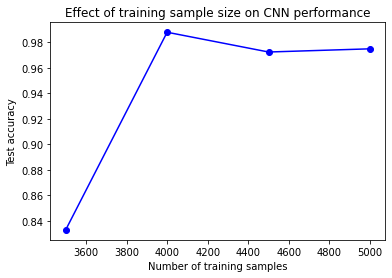

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sample_sizes, history_dict, 'bo-')
plt.xlabel('Number of training samples')
plt.ylabel('Test accuracy')
plt.title('Effect of training sample size on CNN performance')
plt.show()

In [ ]:
# shutil.rmtree(new_base_dir / "temp_train")

PreTrained Network

Question 4

In [ ]:
# Creating directories and assiging images to training, validation and test directories
import os
import shutil
import pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Pretrained")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Training has 1500 samples, test has 500 samples, and validation has 500 samples
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
# Loading pre-trained weights to VGG16 model 
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Defining function to extract features and labels
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
# Extracting the features and labels from datasets
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)
train_features.shape

1/1 [==============================] - 0s 25ms/step


(10000, 5, 5, 512)

In [ ]:
# Building the model 
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Running the callback function to monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# Training the model
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 9.0927 - accuracy: 0.9564 - val_loss: 1.3563 - val_accuracy: 0.9870
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 3.4211 - accuracy: 0.9775 - val_loss: 0.6536 - val_accuracy: 0.9950
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: 1.8822 - accuracy: 0.9858 - val_loss: 0.3014 - val_accuracy: 0.9950
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 1.2669 - accuracy: 0.9890 - val_loss: 0.3193 - val_accuracy: 0.9950
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6366 - accuracy: 0.9922 - val_loss: 0.6106 - val_accuracy: 0.9920
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8781 - accuracy: 0.9913 - val_loss: 0.1561 - val_accuracy: 0.9970
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6042 - accuracy: 0.9923 - val_loss: 0.5746 - val_accuracy: 0.9940
Epoch 

In [ ]:
# Testing the model 
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9990
Test accuracy: 0.999


In [ ]:
# Loading pre-trained weights to the VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
# Freezing the layers of the pretrained CNN 
conv_base.trainable = False

# UnFreezing the layers of the pretrained CNN 
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [ ]:
 # Declaring Data Augumentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
# Building the model and configuring it
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
# Using the callbacks function to monitor validation loss and running the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


350/350 [==============================] - 61s 165ms/step - loss: 12.9627 - accuracy: 0.9276 - val_loss: 2.9566 - val_accuracy: 0.9750
Epoch 2/50
350/350 [==============================] - 58s 163ms/step - loss: 6.2681 - accuracy: 0.9543 - val_loss: 2.8638 - val_accuracy: 0.9730
Epoch 3/50
350/350 [==============================] - 57s 161ms/step - loss: 4.0130 - accuracy: 0.9613 - val_loss: 1.9572 - val_accuracy: 0.9770
Epoch 4/50
350/350 [==============================] - 57s 161ms/step - loss: 2.6229 - accuracy: 0.9613 - val_loss: 1.3409 - val_accuracy: 0.9810
Epoch 5/50
350/350 [==============================] - 59s 168ms/step - loss: 1.7185 - accuracy: 0.9599 - val_loss: 0.6259 - val_accuracy: 0.9810
Epoch 6/50
350/350 [==============================] - 58s 165ms/step - loss: 1.1247 - accuracy: 0.9657 - val_loss: 0.4651 - val_accuracy: 0.9830
Epoch 7/50
350/350 [==============================] - 58s 164ms/step - loss: 0.9025 - accuracy: 0.9660 - val_loss: 0.3845 - val_accuracy: 0.

In [ ]:
# Testing the model 
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 101ms/step - loss: 0.4928 - accuracy: 0.9825
Test accuracy: 0.983


In [ ]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedIncreasedSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


In [ ]:
# Loading pre-trained weights to VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
# conv_base.trainable = False

In [ ]:
# Using the callbacks function to monitor validation loss and running the model
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=3000)

# Building the model 
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Running the callback function to monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# Training the model
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
313/313 [==============================] - 3s 6ms/step - loss: 8.7215 - accuracy: 0.9546 - val_loss: 2.3165 - val_accuracy: 0.9790
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 3.3969 - accuracy: 0.9782 - val_loss: 0.9966 - val_accuracy: 0.9890
Epoch 3/20
313/313 [==============================] - 1s 5ms/step - loss: 1.8710 - accuracy: 0.9850 - val_loss: 0.5527 - val_accuracy: 0.9940
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 1.3099 - accuracy: 0.9885 - val_loss: 0.5060 - val_accuracy: 0.9940
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.7670 - accuracy: 0.9914 - val_loss: 0.2423 - val_accuracy: 0.9970
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6977 - accuracy: 0.9937 - val_loss: 0.1875 - val_accuracy: 0.9980
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6509 - accuracy: 0.9931 - val_loss: 0.1325 - val_accuracy: 0.9990
Epoch 

In [ ]:

# Testing the model 
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.9995
Test accuracy: 0.999


In [ ]:
# Creating directories and assiging images to training, validation and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_PretrainedoptimalSample")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


In [ ]:
# Loading pre-trained weights to VGG16 model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
# Building the model 
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# Train the model with varying training sample sizes
sample_sizes = [2500,3000,4000,5000]
history_dict = []
for size in sample_sizes:
    # Set up the training subset
    make_subset("temp_train", start_index=0, end_index=size)
    make_subset("validation", start_index=size, end_index=size+500)
    make_subset("test", start_index=size+500, end_index=size+1500)
    train_dataset = image_dataset_from_directory(
      new_base_dir / "temp_train", 
      image_size=(180, 180), 
      batch_size=20)
    # Running the callback function to monitor validation loss
    callbacks = [
      keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")]

    # Training the model
    history = model.fit(
      train_features, train_labels,
      epochs=20,
      validation_data=(val_features, val_labels),
      callbacks=callbacks)
    
   # Testing the model 
    test_model = keras.models.load_model("feature_extraction.keras")
    test_loss, test_acc = test_model.evaluate(test_features, test_labels)
    print(f"Test accuracy: {test_acc:.3f}")

Found 5000 files belonging to 2 classes.
Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 7.9265 - accuracy: 0.9550 - val_loss: 1.2610 - val_accuracy: 0.9870
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 3.4520 - accuracy: 0.9788 - val_loss: 0.4244 - val_accuracy: 0.9940
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.7945 - accuracy: 0.9863 - val_loss: 0.3739 - val_accuracy: 0.9960
Epoch 4/20
313/313 [==============================] - 2s 5ms/step - loss: 1.0880 - accuracy: 0.9888 - val_loss: 0.2849 - val_accuracy: 0.9970
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.7931 - accuracy: 0.9917 - val_loss: 0.0332 - val_accuracy: 0.9990
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4479 - accuracy: 0.9944 - val_loss: 0.0186 - val_accuracy: 0.9990
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5779 - accuracy: 0.9937 - val_l